In [1]:
# Import necissary packages

import math
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import datetime
from statsmodels import robust
import matplotlib as mpl
from matplotlib import gridspec
import turtle
from pytz import timezone

# Below are astropy functions

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

# Here are some packages to help find the Vmag

from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

# Found online.  Useful
def rows_uniq_elems(a):
    a_sorted = np.sort(a,axis=-1)
    return a[(a_sorted[...,1:] != a_sorted[...,:-1]).all(-1)]


# The below funciton is one that I created in a seperate py file

from HORIZONS_arraylike import scrapeHORIZONS

# Below is a function I found online to convert from az/el to cartesian

def azel_to_thetaphi(az, el):
    """ Az-El to Theta-Phi conversion.
  
    Args:
        az (float or np.array): Azimuth angle, in radians
        el (float or np.array): Elevation angle, in radians
  
    Returns:
      (theta, phi): Tuple of corresponding (theta, phi) angles, in radians
    """
    
    cos_theta = np.cos(el) * np.cos(az)
    tan_phi   = np.tan(el) / np.sin(az)
    theta     = np.arccos(cos_theta)
    phi       = np.arctan2(np.tan(el), np.sin(az))
    phi = (phi + 2 * np.pi) % (2 * np.pi)
    
    return theta, phi

# Define round time to minute based on code aquired on StackExchange
# We need this because HORIZONS lowest time interval is in minutes

def roundTime(dt=None, roundTo=60):
   """Round a datetime object to any time lapse in seconds
   dt : datetime.datetime object, default now.
   roundTo : Closest number of seconds to round to, default 1 minute.
   Author: Thierry Husson 2012 - Use it as you want but don't blame me.
   """
   if dt == None : dt = datetime.datetime.now()
   seconds = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)



def thetaphis_to_angular_seperation(theta1,phi1,theta2,phi2):
    r=1
    
    x1 = r*np.sin(theta1)*np.cos(phi1)
    y1 = r*np.sin(theta1)*np.sin(phi1)
    z1 = r*np.cos(theta1)
    p1 = np.array([x1,y1,z1])
    
    x2 = r*np.sin(theta2)*np.cos(phi2)
    y2 = r*np.sin(theta2)*np.sin(phi2)
    z2 = r*np.cos(theta2)
    p2 = np.array([x2,y2,z2])
    
    ang_dist = np.rad2deg(np.arccos(np.dot(p1,p2)))
    
    return ang_dist

# Sky Coverage Jupyter Notebook

## Summary

In this notebook, we will use the positioning of stars to calculate the average sky coverage on a perfectly clear night.  By looking at all the .png images and calculating the position of the stars as a function of time (all images are time-stamped), we can try to see how much sky we can observe.  Additionally we can look at the position of the stars relative to one another to calculate the pixel-angular distance ratio.

## Sections:

* ### [Capturing Star Information](#cap)
    * [The Dark Frame](#dark)
    * [Object Detection Setup](#obj)
    * [From Videos](#abcd)
    * [From Pictures](#efgh)
    
    
* ### [Analysis](#anal)
    * [Same object, different times](#sodt)
    * [Same time, different object](#stdo)
    
    
* ### [Data Manipulation](#data)  \* note to run analysis before this
    * [Manipulate the combined Data Frames](#man)
   

* ### [Extra Plotting](#extra)
    * [Visualize the data](#vis)
    * [Divide into squares](#div)

# Capturing Star Information <a name="cap"></a>

Here we will delve into a few different things:

* Dark Frame - Calculating what stars are actually hot pixels

* Object Detection Setup - Setting parameters for SimpleBlobDetector

* For Videos - Analyzing the videos in search of objects

* For Pictures - Analyzing images in search of objects


The main goal is to end up with a table that includes various properties of the objects in question.  These can then be analyzed in the next section.

## The Dark Frame  <a name="dark"></a>

We will be using this dark frame to capture hot pixels which we can then subtract from our videos/pictures to get rid of "phony" stars


Note: **th3** is the name of the end product dark frame

In [4]:
vidpath2 = '/home/pj/UsbStick/starz/'

# Load Dark vid
vid = cv2.VideoCapture(vidpath2+'dark.avi')

# Start at first frame
vid.set(1,1)
# Read video
ret, frame = vid.read()
# Convert to black and white
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
# Create Copy of first frame
init = frame.copy()

# Set initial large stack number
stacksize = 10000

frame = frame.astype(float)
for i in range(stacksize):
    # Read in frame
    ret, newframe = vid.read()
    if not ret:
        # Find how many stacks are in the video and redefine it
        stacksize = i
        break
    # Make black and white but change to float to not run into int problem
    newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
    # Add fractional average to stacked frame
    frame = cv2.add(frame, cv2.divide(newframe, stacksize))


#####################################

# Reset process with known stacksize

vid.set(1,1)
ret, frame = vid.read()
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
init = frame.copy()

frame = frame.astype(float)
for i in range(stacksize):
    ret, newframe = vid.read()
    if not ret:
        print('Something is wrong...')
    newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
    frame = cv2.add(frame, cv2.divide(newframe, stacksize))
frame = cv2.convertScaleAbs(frame)
ret3,th3 = cv2.threshold(frame,140,255,cv2.THRESH_BINARY)

## Object Detection Setup <a name="obj"></a>

In [5]:
#Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByInertia = False
params.filterByConvexity = False
# We want white things
params.filterByColor = True
params.blobColor = 255
# We want small things
params.filterByArea = True
params.maxArea = 20
params.minArea = 1
# We want fairly circular things
params.filterByCircularity = True
params.minCircularity = 0.5

# Set detector to look for specified parameters
detector = cv2.SimpleBlobDetector_create(params)

## From Videos <a name="abcd"></a>

In [6]:
# List directory contents and create list of avi videos

vidpath = '/home/pj/UsbStick/Video/'
vidpath2 = '/home/pj/UsbStick/starz/'

dircontents = np.array(os.listdir(vidpath))
cond = [(file[-4:] == '.avi') for file in dircontents]
onlyvids = dircontents[cond]

onlyvids = set(onlyvids)-{'dark.avi'}
onlyvids = np.array(list(onlyvids))

# Read in catalog and see if we have already analyzed the video
data = pd.read_csv("Starz_and_vid_catalog.csv", delimiter=' ') 
cond09 = np.invert([onlyvids[i] in np.unique(np.array(data)[:,1]) for i in np.arange(0,len(onlyvids))])
onlyvids = onlyvids[cond09]

badvids = np.loadtxt('bad_vids.txt', dtype='str', usecols=0)
badvids = np.array([badvids[i] for i in np.arange(0,len(badvids))])

onlyvids = set(onlyvids) - set(badvids)
onlyvids = np.array(list(onlyvids))

in_order = sorted(onlyvids, key=lambda x: datetime.datetime.strptime(x, '%Y%m%d_%H%M%S.avi'))
onlyvids = in_order[::-1]
len(onlyvids)

0

In [7]:
path = vidpath

for i in np.arange(0,len(onlyvids)):
    
    wack = 0
    
    # Set up data array 
    data_array = np.chararray((100,11),itemsize=20)
    present_row = int(0)
    
    # Look at video
    vid = cv2.VideoCapture(path+onlyvids[i])
    vid.set(1,1)
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    init = frame.copy()
    

    stacksize = 10000

    frame = frame.astype(float)
    for j in range(stacksize):
        ret, newframe = vid.read()
        if not ret:
            stacksize = j
            break
        newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
        frame = cv2.add(frame, cv2.divide(newframe, stacksize))
    frame = cv2.convertScaleAbs(frame)
    
    ##################################################
    
    vid = cv2.VideoCapture(path+onlyvids[i])
    vid.set(1,1)
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    init = frame.copy()
    
    
    frame = frame.astype(float)
    for j in range(stacksize):
        ret, newframe = vid.read()
        if not ret:
            print('WTF!!!!!')
        newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
        frame = cv2.add(frame, cv2.divide(newframe, stacksize))
    frame = cv2.convertScaleAbs(frame)
    
    
    
    
    # Subtract dark frame to get rid of hot spots
    new = cv2.subtract(frame,th3)

    # Set original threshold
    thresh = 140
    
    # Threshold the image to try to find stars
    ret4,th4 = cv2.threshold(new,thresh,255,cv2.THRESH_BINARY)
    
    ##############################################
    # Check to see if threshold is sufficient
    ##############################################
    
    plt.imshow(th4, cmap='gray')
    plt.show()
    q1 = input('Is this threshold sufficient?')
    if q1 == 'n':
        bad = 0
        while bad == 0:
            thresh += 5
            ret4,th4 = cv2.threshold(new,thresh,255,cv2.THRESH_BINARY)
            fig = plt.figure(figsize=(5,5))
            plt.title(str(thresh))
            plt.imshow(th4, cmap='gray')
            plt.show()
            q2 = input('How about now?')
            if q2 == 'y':
                bad = 1
                plt.clf()
    
    ##############################################
    
    # Detect keypoints and find their locations
    keypoints = detector.detect(th4)
    x = [keypoints[j].pt[0] for j in np.arange(0,len(keypoints))]
    y = [keypoints[j].pt[1] for j in np.arange(0,len(keypoints))]
    locarray = np.column_stack((x,y))
    
    
    plt.figure(figsize=(12,18))
    ax = plt.subplot(111)

    plt.imshow(th4, cmap='gray',vmax=100, vmin=50)

    for j in np.arange(0,len(x)):
        circle = plt.Circle((x[j], y[j]), 10, color='r', fill=False)
        ax.add_artist(circle)
        text = plt.annotate(str(j),(x[j]+10,y[j]+10), color='r')
        text.set_fontsize(20)

        
    nice_date = onlyvids[i][:4]+'-'+onlyvids[i][4:6]+'-'+onlyvids[i][6:8]
    nice_time = onlyvids[i][9:11]+':'+onlyvids[i][11:13]    
    plt.title(nice_date+'   '+nice_time)
    plt.tight_layout()
    plt.show()
    
    
    # Format date and time correctly
    date = onlyvids[i][:4]+'-'+onlyvids[i][4:6]+'-'+onlyvids[i][6:8]
    time = onlyvids[i][9:11]+':'+onlyvids[i][11:13]+':'+onlyvids[i][13:15]
    date_time = date+' '+time
    
    data_array1=[]
    
    for j in np.arange(0,len(x)):
        wack = 0
        input_star = input('What is object #'+str(j)+'?    ')
        
        if input_star == 'bad':
            f = open('bad_vids.txt','a')
            f.write(onlyvids[i]+'\n')
            f.close()
            wack = 1
            break
            break
            
            
            
            
            
            
            
        
        elif input_star == 'skip':
            break
            break
        
        elif len(input_star)>2:
            # Use astropy to find correct star information
            star = SkyCoord.from_name(input_star)

            # Choose correct observing location and time
            salem_roof = EarthLocation(lat=44.937309*u.deg, lon=-123.031752*u.deg, height=57*u.m)
            utcoffset = -7*u.hour  # Pacific Daylight Time
            time = Time(date_time) - utcoffset


            # Find az and el of star that we are looking at
            star_altaz = star.transform_to(AltAz(obstime=time,location=salem_roof))
            alt = np.deg2rad(star_altaz.alt.deg)
            az = np.deg2rad(star_altaz.az.deg)
            
            # Find Vmag of star
            catalog_list = Vizier.query_object(input_star,catalog='Simbad')
            jmags = np.array(catalog_list[0]['Vmag'])
            jmags = jmags[~np.isnan(jmags)]
            vmag = np.average(jmags)
            
            # Collect everything that we want to put in array
            a0 = onlyvids[i]
            a1 = date_time
            a2 = input_star
            a3 = str(star.ra.deg)
            a4 = str(star.dec.deg)
            a5 = str(vmag)
            a6 = str(alt)
            a7 = str(az)
            a8 = str(x[j])
            a9 = str(y[j])
            a10 = 'real'
            
            row = [a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10]
            
            data_array[present_row] = row
            
            present_row += 1
    cond = (data_array[:,-1] == b'real')
    data_array1 = data_array[cond]
    
    if (len(data_array1)>0)&(wack== 0):
        data_array1 = data_array1.decode('utf-8')
        df = pd.DataFrame(data_array1[:,:-1])
        df.to_csv('/home/pj/Documents/Thesis/Starz_and_vid_catalog.csv', sep=' ', mode='a', header=False)
        
        


# [^ To Video Start ^](#abcd)

## From Pictures  <a name="efgh"></a>

In [8]:
# List directory contents and create list of avi videos

vidpath = '/home/pj/UsbStick/Video/'
vidpath2 = '/home/pj/UsbStick/starz/vids/'


# Look at specific directory and scan it for png images

cond = [(file[-4:] == '.png') for file in dircontents]
onlypics = dircontents[cond]

data = pd.read_csv("Starz_and_vid_catalog.csv", delimiter=' ') 
cond09 = np.invert([onlypics[i] in np.unique(np.array(data)[:,1]) for i in np.arange(0,len(onlypics))])
onlypics = onlypics[cond09]


badvids = np.loadtxt('bad_vids.txt', dtype='str', usecols=0)
badvids = np.array([badvids[i] for i in np.arange(0,len(badvids))])

onlypics = set(onlypics) - set(badvids)
onlypics = np.array(list(onlypics))

in_order = sorted(onlypics, key=lambda x: datetime.datetime.strptime(x, '%Y%m%d_%H%M%S_Snap.png'))
onlypics = in_order[::-1]
len(onlypics)

0

In [9]:
path = vidpath

for i in np.arange(0,len(onlypics)):
    wack=0
    pic = cv2.imread(path+onlypics[i])
    
    data_array = np.chararray((100,11),itemsize=50)
    data_array[:] = 'b'
    
    present_row = int(0)
    
    frame = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    new = cv2.subtract(frame,th3)
    thresh = 70
    ret4,th4 = cv2.threshold(new,thresh,255,cv2.THRESH_BINARY)
    date = onlypics[i][:4]+'-'+onlypics[i][4:6]+'-'+onlypics[i][6:8]
    time = onlypics[i][9:11]+':'+onlypics[i][11:13]+':'+onlypics[i][13:15]
    date_time = date+' '+time
    plt.imshow(th4, cmap='gray')
    plt.show()
    q1 = input('Is this threshold sufficient?')
    if q1 == 'n':
        bad = 0
        while bad == 0:
            thresh += 5
            ret4,th4 = cv2.threshold(new,thresh,255,cv2.THRESH_BINARY)
            plt.imshow(th4, cmap='gray')
            plt.show()
            q2 = input('How about now?')
            if q2 == 'y':
                bad = 1
                plt.clf()
    print('\n\n\n'+onlypics[i][:4]+'-'+onlypics[i][4:6]+'-'+onlypics[i][6:8])
    print(onlypics[i][9:11]+':'+onlypics[i][11:13])
    
    
    plt.figure(figsize=(12,18))
    ax = plt.subplot(111)
    
    keypoints = detector.detect(th4)
    x = [keypoints[j].pt[0] for j in np.arange(0,len(keypoints))]
    y = [keypoints[j].pt[1] for j in np.arange(0,len(keypoints))]
    locarray = np.column_stack((x,y))
    
    for j in np.arange(0,len(x)):
        circle = plt.Circle((x[j], y[j]), 10, color='r', fill=False)
        ax.add_artist(circle)
        text = plt.annotate(str(j),(x[j]+10,y[j]+10), color='r')
        text.set_fontsize(20)

       
    nice_date = onlypics[i][:4]+'-'+onlypics[i][4:6]+'-'+onlypics[i][6:8]
    nice_time = onlypics[i][9:11]+':'+onlypics[i][11:13]    
    plt.title(nice_date+'   '+nice_time)
    plt.tight_layout()
    
    plt.imshow(th4, cmap='gray')
    plt.show()
    
    data_array1=[]
    
    for j in np.arange(0,len(x)):
        wack=0
        input_star = input('What is object #'+str(j)+'?    ')
        
        if input_star == 'bad':
            f = open('bad_vids.txt','a')
            f.write(onlypics[i]+'\n')
            f.close()
            wack = 1
            break
            break
        
        elif input_star == 'skip':
            wack=1
            break
        
        if (len(input_star)>2):
            # Use astropy to find correct star information
            star = SkyCoord.from_name(input_star)

            # Choose correct observing location and time
            salem_roof = EarthLocation(lat=44.937309*u.deg, lon=-123.031752*u.deg, height=57*u.m)
            utcoffset = -7*u.hour  # Pacific Daylight Time
            time = Time(date_time) - utcoffset


            # Find az and el of star that we are looking at
            star_altaz = star.transform_to(AltAz(obstime=time,location=salem_roof))
            alt = np.deg2rad(star_altaz.alt.deg)
            az = np.deg2rad(star_altaz.az.deg)
            
            # Find Vmag of star
            catalog_list = Vizier.query_object(input_star,catalog='Simbad')
            jmags = np.array(catalog_list[0]['Vmag'])
            jmags = jmags[~np.isnan(jmags)]
            vmag = np.average(jmags)
            
            # Collect everything that we want to put in array
            a0 = onlypics[i]
            a1 = date_time
            a2 = input_star
            a3 = str(star.ra.deg)
            a4 = str(star.dec.deg)
            a5 = str(vmag)
            a6 = str(alt)
            a7 = str(az)
            a8 = str(x[j])
            a9 = str(y[j])
            a10 = 'real'
            
            row = [a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10]
            data_array[present_row] = row
        
        
        
        
        
            print('Check!')
            present_row += 1
            
    cond = data_array[:,-1] == b'real'
    data_array1 = data_array[cond]
    
    if (len(data_array1)>0)&(wack== 0):
        data_array1 = data_array1.decode('utf-8')
        df = pd.DataFrame(data_array1[:,:-1])
        df.to_csv('/home/pj/Documents/Thesis/Starz_and_vid_catalog.csv', sep=' ', mode='a', header=False)
    


# [^ To Picture Start ^](#efgh)

# Analysis <a name="anal"></a>

Here we will delve into a few different things:

* Same Object, Different Times - Look at same object over many nights

* Same Time, Different Objects - Connect between multiple stars in same image/video

The goal of this section is to get a table that shows the different angular distance per pixel ratios throughout various regions of the visible sky.  Knowing this information, along with the locations/names of the objects we use to calculate them, we can move on to analyzing them.

In [2]:
data = pd.read_csv("Starz_and_vid_catalog.csv", delimiter=' ',usecols=np.arange(1,11)) 

### Comparing all items in 1 night <a name="sodt"></a>

In [3]:
startendz = np.array(pd.read_csv('start_end_observations.csv'))


datetime_array1 = np.array(data['Datetime'])
datetime_array2 = [datetime.datetime.strptime(datetime_array1[i], '%Y-%m-%d %H:%M:%S') for i in np.arange(0,len(datetime_array1))]
datetime_array = [timezone('UTC').localize(datetime_array2[i]) for i in np.arange(0,len(datetime_array2))]

datetime_array = np.array(datetime_array)

In [4]:
tot = []

# Make large empty array
empty3 = np.chararray((100000,18), itemsize=100)
empty3[:] = ''

index=0


for i in np.arange(0,len(startendz)):
    # Pick start time
    start = startendz[i,0]
    start = datetime.datetime.strptime(start, '%Y/%m/%d %H:%M:%S')
    start = timezone('US/Pacific').localize(start)
    
    # Pick end time
    end = startendz[i,1]
    end = datetime.datetime.strptime(end, '%Y/%m/%d %H:%M:%S')
    end = timezone('US/Pacific').localize(end)
    
    # Only look for rows that fall within 1 observation run
    cond1 = [(start<=datetime_array[j]) for j in np.arange(0,len(datetime_array))]
    cond2 = [(end>datetime_array[j]) for j in np.arange(0,len(datetime_array))]
    cond1 = np.array(cond1)
    cond2 = np.array(cond2)
    cond_both = cond1&cond2
    
    # Enact condition on array
    rows_in_same_night = data.loc[cond_both]
    np_rows = np.array(rows_in_same_night)
    tot = np.hstack((tot,np_rows[:,0]))
    
    if len(np_rows)>1:
        a = b = np.arange(0,len(np_rows))
        combos = (np.array(np.meshgrid(a, b)).T.reshape(-1,2))
        combos = np.sort(combos,axis=1)
        cond = [(combos[j,0] != combos[j,1]) for j in np.arange(0,len(combos))]
        combos = combos[np.array(cond)]
        indexes = rows_uniq_elems(combos)
        for j in np.arange(0,len(indexes)):
            one = indexes[j,0]
            two = indexes[j,1]
            
            
            t1 = np_rows[one,1]
            s1 = np_rows[one,2]
            xloc1 = np_rows[one,8]
            yloc1 = np_rows[one,9]
            alt1 = np_rows[one,6]
            az1 = np_rows[one,7]
                
            t2 = np_rows[two,1]
            s2 = np_rows[two,2]
            xloc2 = np_rows[two,8]
            yloc2 = np_rows[two,9]
            alt2 = np_rows[two,6]
            az2 = np_rows[two,7]
                
            xs = [xloc1,xloc2]
            ys = [yloc1,yloc2]
                
            #  az and el -> spherical -> cartesian 
            theta1, phi1 = azel_to_thetaphi(az1,alt1)
            theta2, phi2 = azel_to_thetaphi(az2,alt2)
            ang_dist = thetaphis_to_angular_seperation(theta1,phi1,theta2,phi2)
                
            # Find time difference
            
            
            two_times = sorted([t1,t2], key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
            t1_datetime = datetime.datetime.strptime(two_times[1], '%Y-%m-%d %H:%M:%S')
            t2_datetime = datetime.datetime.strptime(two_times[0], '%Y-%m-%d %H:%M:%S')

            t_dif = np.float((t1_datetime-t2_datetime).seconds)
                
            # Find pixel difference
            pix_dif = np.sqrt((xloc2-xloc1)**2 + (yloc2-yloc1)**2)
                
            # Find midpoint location
            pix_mid_x = sum(xs)/2
            pix_mid_y = sum(ys)/2
                
            # Deal with polaris cases where it doesn't move
            if pix_dif == 0:
                ratio = 'same_loc'
            else:
                ratio = ang_dist/pix_dif
                
            # Group important stuff together
            important_stuff = np.array([t1,s1,xloc1,yloc1,alt1,az1,
                                        t2,s2,xloc2,yloc2,alt2,az2,
                                        t_dif,pix_dif,ang_dist,
                                        pix_mid_x,pix_mid_y,ratio])
            empty3[index] = important_stuff
            index += 1
            
            
# Get rid of pesky b'' problem
empty3 = empty3.decode('utf-8')

# Get rid of empty rows
cond13 = np.array([len(empty3[i,:][0])>1 for i in np.arange(0,len(empty3))])
data13 = pd.DataFrame(empty3[cond13])

# Make sure each row is unique
data23 = data13.drop_duplicates()

# Label columns to make things pretty
data23.columns = ['time1', 'object1', 'xloc1', 'yloc1', 'alt1', 'az1',
                 'time2', 'object2', 'xloc2', 'yloc2', 'alt2', 'az2',
                 'time_dif', 'pix_dif', 'ang_dist', 'pix_mid_x',
                 'pix_mid_y','ratio']

In [5]:
# Forget what 
set(data['Vid_name']) -set(tot)

{'20180801_225706.avi', '20180801_231337.avi'}

# Data Manipulation <a name="data"></a>

In this section, we will develop a method for finding the angular distance / pixel for different regions of the nights sky.  This will be useful for calculating the total area of the sky along with the area of clouds covering different regions of the sky.

We will delve into a few different things in this section:

* Manipulate the Combined Data Frames
    * Get rid of Polaris -> Polaris cases and other weird ones
* Visualize the Data
    * See what we're working with
* Divide image into squares
    * Calculate average ang/pix ratio in different regions
 

## Manipulate the Combined DataFrames <a name="man"></a>

In [6]:
moondata = pd.read_csv("moon_ratios.csv", delimiter=' ')

# Combine 'Same Object Different Nights' and 'Same Night Different Object'
two_data = pd.DataFrame(data23)

# Get rid of problem with pix_mid_x&y
two_data['pix_mid_x'] = (two_data['xloc1'].astype(float) + two_data['xloc2'].astype(float)) / 2
two_data['pix_mid_y'] = (two_data['yloc1'].astype(float) + two_data['yloc2'].astype(float)) / 2

# Merge star and moon data
both_data = pd.concat((two_data,moondata))

In [8]:
# Create conditions to manipulate what we are looking at in our main data table

short_time = both_data[both_data['time_dif'].astype(float)>(60)]


# Get array of [pixel seperation, angular seperation, time elapsed, xloc1, yloc1, xloc2, yloc2]

long_pix_sep = short_time[short_time['pix_dif'].astype(float)>2]
dist_ang_dt_xmid_ymid = long_pix_sep[['ratio','pix_mid_x','pix_mid_y']]

dist_ang_dt_xmid_ymid = np.array(dist_ang_dt_xmid_ymid).astype(float)

adjusted_for_pix1 = dist_ang_dt_xmid_ymid

adjusted_for_pix12 = adjusted_for_pix1[adjusted_for_pix1[:,0]<1]


long_pix_sep.to_csv('/home/pj/Documents/Thesis/star_comparisons.csv')

# Extra Plotting <a name="extra"></a>

## Visualize Created Table <a name="vis"></a>

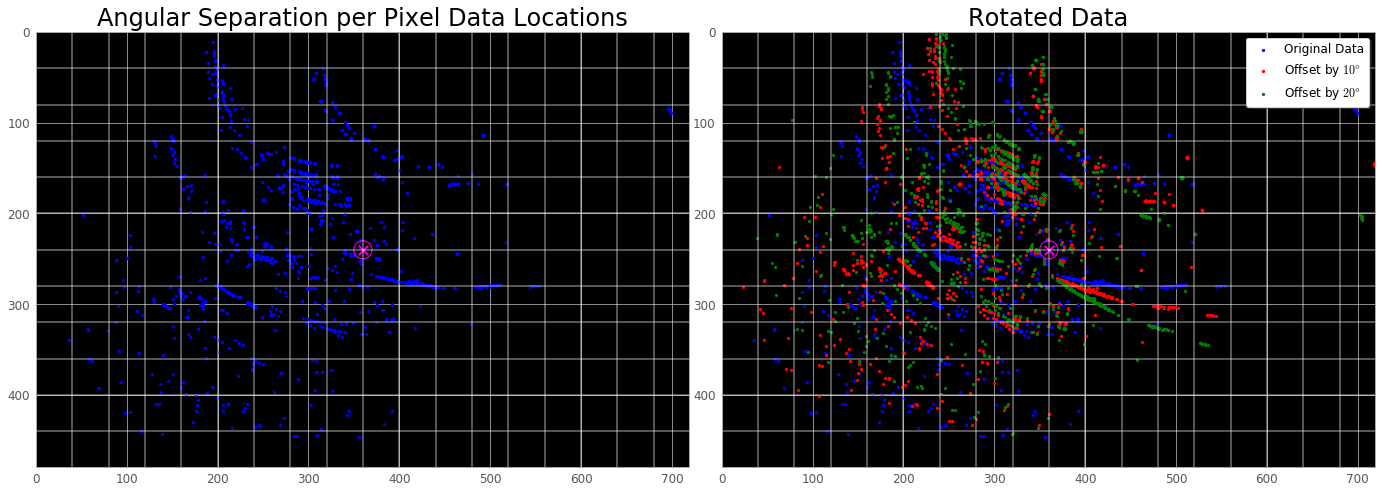

In [12]:
xmid2 = 719/2
ymid2 = 479/2

fig = plt.figure(figsize=(24,8))
fig.set_facecolor('white')


ax = plt.subplot(121)

for i in np.arange(0,720,40):
    plt.axvline(i,color='white',alpha=0.4)
    if i<481:
        plt.axhline(i,color='white',alpha=0.4)

ax.set_facecolor('black')
plt.scatter(adjusted_for_pix1[:,1],adjusted_for_pix1[:,2],s = 5,color='blue')
plt.xlim(0,719)
plt.ylim(479,0)
plt.title('Angular Separation per Pixel Data Locations', fontsize=24)
cent = plt.Circle((360, 240), 10, color='fuchsia', fill=False)
ax.add_artist(cent)
plt.scatter(360,240,marker='x',color='fuchsia',s=90)

ax1 = plt.subplot(122)

for i in np.arange(0,720,40):
    plt.axvline(i,color='white',alpha=0.4)
    if i<481:
        plt.axhline(i,color='white',alpha=0.4)

ax1.set_facecolor('black')

##########################################################
ang = np.deg2rad(10)
a1 = adjusted_for_pix1[:,1] - 720/2
a2 = adjusted_for_pix1[:,2] - 480/2
rotated1 = ((np.cos(ang)*a1) - (np.sin(ang)*a2)) + 720/2
rotated2 = ((np.sin(ang)*a1) + (np.cos(ang)*a2)) + 480/2
##########################################################

ang2 = np.deg2rad(20)

rotated10 = ((np.cos(ang2)*a1) - (np.sin(ang)*a2)) + 720/2
rotated20 = ((np.sin(ang2)*a1) + (np.cos(ang)*a2)) + 480/2
##########################################################

plt.scatter(adjusted_for_pix1[:,1],adjusted_for_pix1[:,2],s = 5,color='blue',
           label='Original Data')
plt.scatter(rotated1,rotated2,s = 5,color='red',
           label='Offset by $10$'+r'$\degree$')
plt.scatter(rotated10,rotated20,s = 5,color='green',
           label='Offset by $20$'+r'$\degree$')
plt.xlim(0,719)
plt.ylim(479,0)
plt.title('Rotated Data', fontsize=24)
cent = plt.Circle((360, 240), 10, color='fuchsia', fill=False)
ax1.add_artist(cent)
plt.scatter(360,240,marker='x',color='fuchsia',s=90)

plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
plt.style.use('classic')
plt.subplots_adjust(wspace=0.05, hspace=0)

plt.show()

#fig.savefig('images/rotated_pixels.png', bbox_inches='tight')

In [13]:
# Get rid of cases where ratio is super high!

adjusted_for_pix12 = adjusted_for_pix1[adjusted_for_pix1[:,0]<0.5]

file1 = open('loc_and_ratios.txt','w')
for i in np.arange(0,len(adjusted_for_pix12)):
    file1.write(str(adjusted_for_pix12[i,0])+'    '+
               str(adjusted_for_pix12[i,1])+'    '+
                str(adjusted_for_pix12[i,2])+'\n')
file1.close()

###########################
# Run so we can get images
###########################

# List directory contents and create list of avi videos


vidpath = '/home/pj/UsbStick/Video/'
vidpath2 = '/home/pj/UsbStick/starz/vids/'


dircontents = np.array(os.listdir(vidpath))



# Look at specific directory and scan it for png images

cond = [(file[-4:] == '.png') for file in dircontents]
onlypics = dircontents[cond]

data = pd.read_csv("Starz_and_vid_catalog.csv", delimiter=' ') 
cond09 = np.invert([onlypics[i] in np.unique(np.array(data)[:,1]) for i in np.arange(0,len(onlypics))])
onlypics = onlypics[cond09]


badvids = np.loadtxt('bad_vids.txt', dtype='str', usecols=0)
badvids = np.array([badvids[i][2:-1] for i in np.arange(0,len(badvids))])

onlypics = set(onlypics) - set(badvids)
onlypics = np.array(list(onlypics))

in_order = sorted(onlypics, key=lambda x: datetime.datetime.strptime(x, '%Y%m%d_%H%M%S_Snap.png'))
onlypics = in_order[::-1]

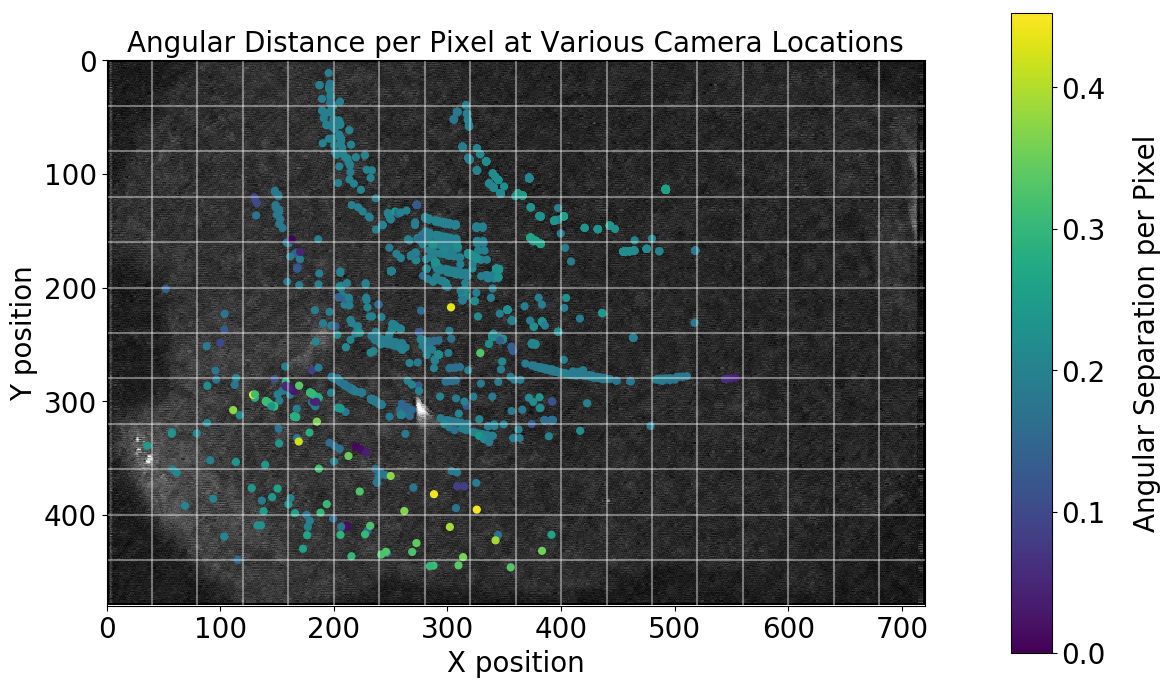

In [45]:
plt.style.use('default')
import matplotlib
import matplotlib.pylab
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Make a figure that is split so we can see a nice colorbar

fig=plt.figure(figsize=(2*7,2*4))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1]) 

# Make colored circles at moon center locations for
# various angular distance/pixel measurments


ax = plt.subplot(gs[0])
for i in np.arange(0,len(adjusted_for_pix12)):
    #xmid = (adjusted_for_pix12[i,3])
    #ymid = (adjusted_for_pix12[i,4])
    #pixadj = adjusted_for_pix12[i,1]/max(adjusted_for_pix12[:,1])
    xmid = (adjusted_for_pix12[i,1])
    ymid = (adjusted_for_pix12[i,2])
    pixadj = adjusted_for_pix12[i,0]/max(adjusted_for_pix12[:,0])
    circle1 = plt.Circle((xmid,ymid),3,color=plt.cm.viridis(int(pixadj*255)))
    ax.add_artist(circle1)
    
for i in np.arange(0,720,40):
    plt.axvline(i,color='white',alpha=0.4)
    if i<481:
        plt.axhline(i,color='white',alpha=0.4)
    
# Get empty image that displays our camera system
vidcap = cv2.VideoCapture('/home/pj/UsbStick/Video/'+onlypics[4])
img0 = vidcap.read()[1]

# Convert to grayscale
img1 = cv2.cvtColor(img0,cv2.COLOR_RGB2GRAY)
plt.imshow(img1, cmap='gray')

#Work on making colorbar
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cmap = mpl.cm.viridis
#norm = mpl.colors.Normalize(vmin=0,vmax=max(adjusted_for_pix12[:,1]))
norm = mpl.colors.Normalize(vmin=0,vmax=max(adjusted_for_pix12[:,0]))
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='vertical')


# Set labels and titles
cb1.set_label('Angular Distance per Pixel')
ax.set_xlim(0,720)
ax.set_ylim(480,0)
ax.set_xlabel('X position',fontsize=20)
ax.set_ylabel('Y position',fontsize=20)
ax.set_title('Angular Distance per Pixel at Various Camera Locations',fontsize=20)

cbytick_obj = plt.getp(cb1.ax.axes, 'yticklabels')                #tricky
plt.setp(cbytick_obj, color='black')

plt.ylabel('Y', labelpad=15,fontsize=20)
cb1.set_label('Angular Separation per Pixel', labelpad=20, color='black')
matplotlib.pylab.rc('font', family='serif', size=20)
#plt.xlabel('X', labelpad=15, fontsize=20)


plt.show()
#fig.savefig('images/angular_distance_at_various_locations.png',bbox_inches='tight')

## Divide into squares <a name="div"></a>

In [126]:
inc = 40
xdivs = np.arange(0,720+inc,inc)
ydivs = np.arange(0,480+inc,inc)
ydivs = ydivs[::-1]

In [127]:
empty = np.zeros((len(ydivs)-1,len(xdivs)-1))

for i in np.arange(0,len(xdivs)-1):
    left = xdivs[i]
    right = xdivs[i+1]
    for j in np.arange(0,len(ydivs)-1):
        bottom = ydivs[j+1]
        top = ydivs[j]
        cond_x = ((adjusted_for_pix12[:,1] >= left)&(adjusted_for_pix12[:,1] < right))
        cond_y = ((adjusted_for_pix12[:,2] >= bottom)&(adjusted_for_pix12[:,2] < top))
        cond_both = (cond_x&cond_y)
        subset = adjusted_for_pix12[cond_both]
        
        if len(subset) > 0:
            empty[j,i] = np.average(subset[:,0])
        else:
            empty[j,i] = 0

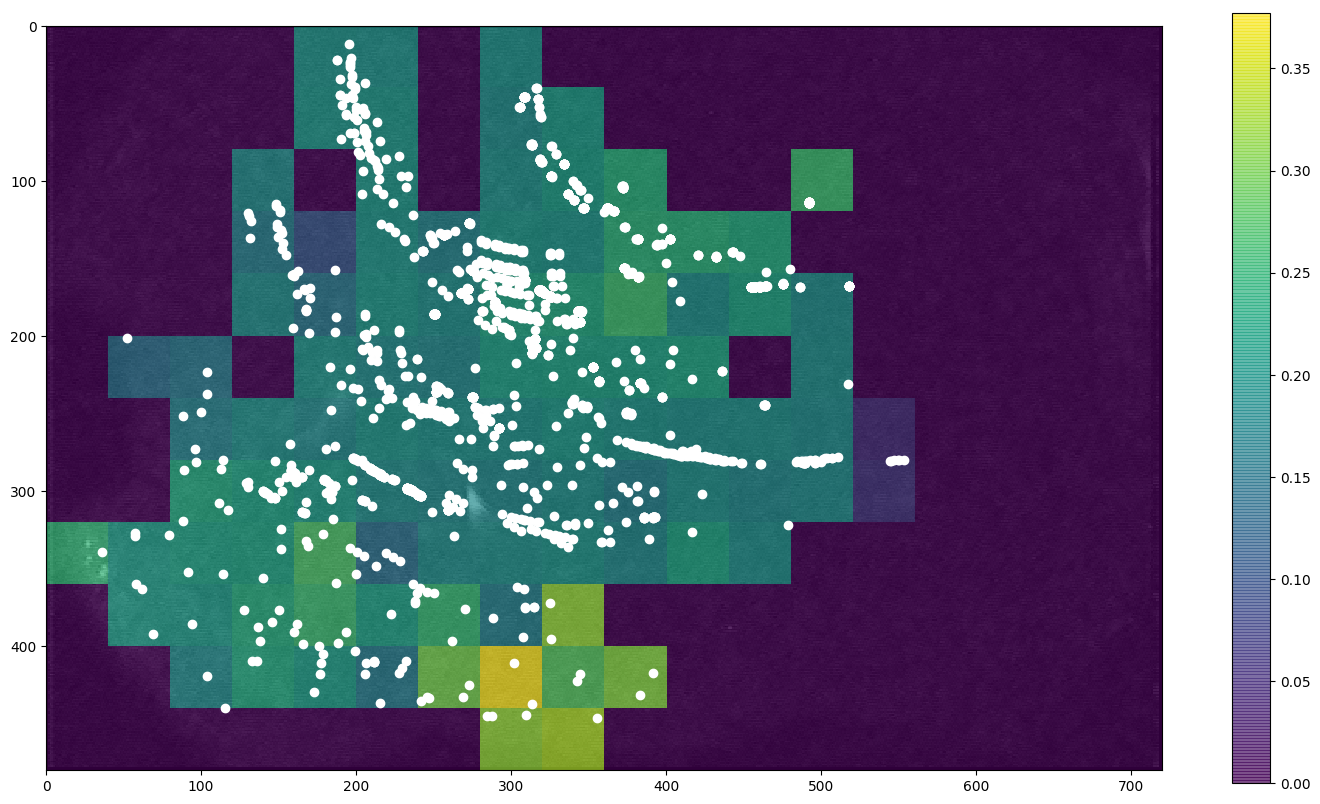

In [128]:
fig = plt.figure(figsize=(18,10))

plt.imshow(img1, cmap='gray')

plt.imshow(empty,
           cmap = 'viridis', #setting the color map
           origin = 'lower', # IMPORTANT, or else the upper left will be your origin!
           extent = [0,720,480,0], # imshow doesn't know the boundaries otherwise
           alpha=0.7
          )

plt.colorbar()
plt.scatter(adjusted_for_pix12[:,1],adjusted_for_pix12[:,2], color='white')


plt.ylim(480,0)
plt.xlim(0,720)

plt.show()

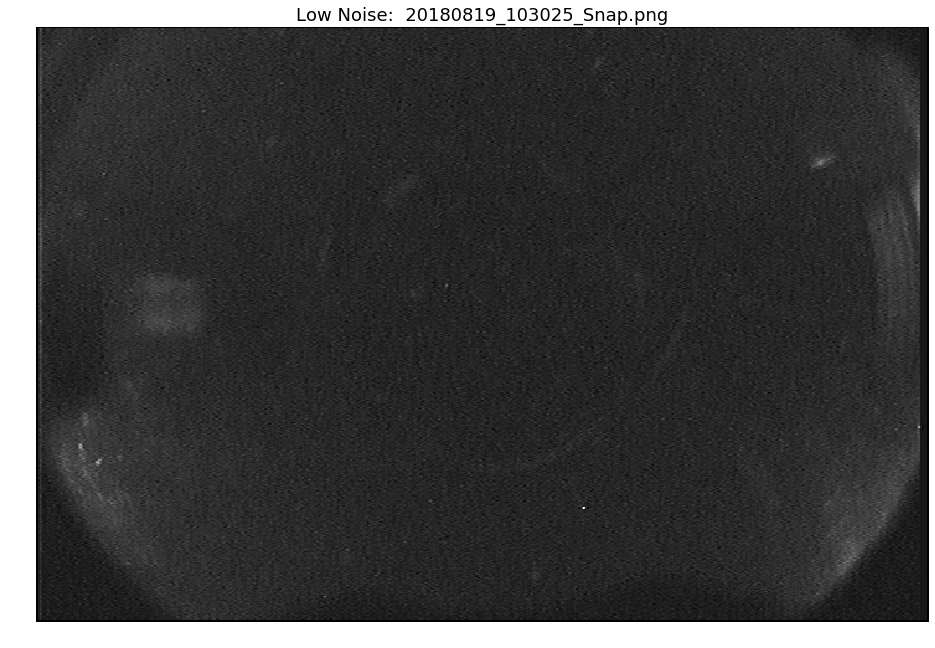

In [11]:
# List directory contents and create list of avi videos
path = '/home/pj/UsbStick/Video/'
dircontents = np.array(os.listdir(path))

# Look at specific directory and scan it for png images
cond = [(file[-4:] == '.png') for file in dircontents]
onlypics = dircontents[cond]

# Sort by date most recent
in_order = sorted(onlypics, key=lambda x: datetime.datetime.strptime(x, '%Y%m%d_%H%M%S_Snap.png'))
onlypics = in_order[::-1]
len(onlypics)


# Good 394, 442, 459, 560, 549
# Bad 16, 28, 47, 117

fig = plt.figure(figsize=(16,14))

ax1 = plt.subplot(111)

pic_good = cv2.imread(path+onlypics[549])
pic2_good = cv2.cvtColor(pic_good, cv2.COLOR_RGB2GRAY)
plt.imshow(pic2_good,cmap='gray')
plt.title('Low Noise:  '+str(onlypics[549]), fontsize=18)
plt.axis('off')
plt.show()
#fig.savefig('images/low_and_high_noise.png', bbox_inches='tight')

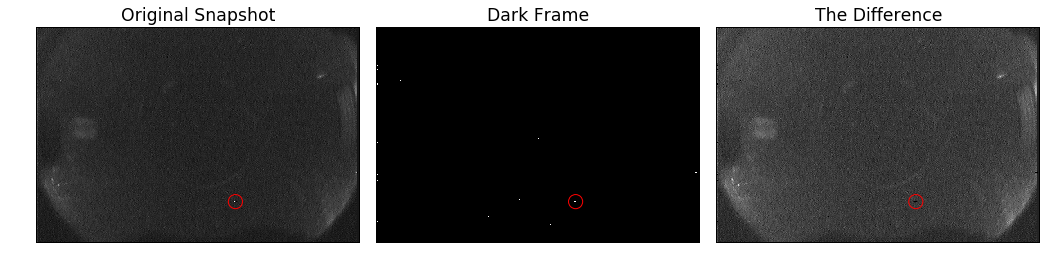

In [54]:
pic_good = cv2.imread(path+onlypics[549])
pic2_good = cv2.cvtColor(pic_good, cv2.COLOR_RGB2GRAY)


fig = plt.figure(figsize=(18,14))

plt.subplot(131)
plt.imshow(pic2_good,cmap='gray')
plt.title('Original Snapshot')

plt.scatter(443, 388, s=200, facecolors='none', edgecolors='r')
plt.axis('off')
plt.subplot(132)
plt.axis('off')
plt.title('Dark Frame')
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9,9))
closing = cv2.dilate(th3, kernel, iterations=0)

plt.scatter(443, 388, s=200, facecolors='none', edgecolors='r')



plt.imshow(closing,cmap='gray')


plt.subplot(133)
plt.title('The Difference')
plt.axis('off')
pic2_better = cv2.subtract(pic2_good,th3)
plt.scatter(443, 388, s=200, facecolors='none', edgecolors='r')
plt.imshow(pic2_better,cmap='gray')


plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

#fig.savefig('images/og_darkframe_difference.png', bbox_inches='tight')

## Hot Spots <a name="hotspots"></a>

(-0.5, 719.5)


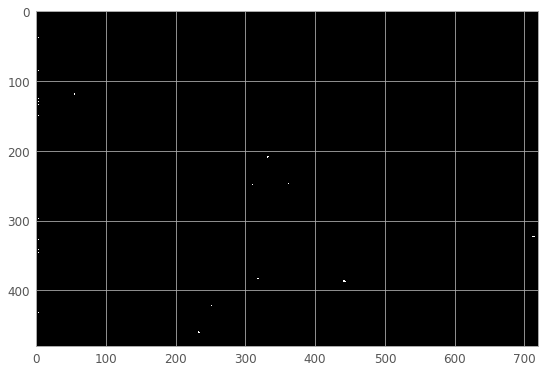

In [16]:
fig = plt.figure(figsize=(9,9))
plt.imshow(th3)
print(plt.xlim())
#plt.xlim(700,720)
plt.show()

## Images for Thesis

'20180921_091141.avi'

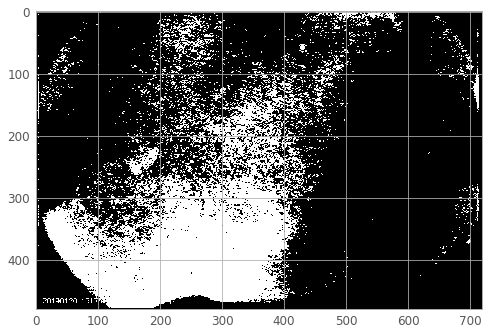

Is this threshold sufficient?n


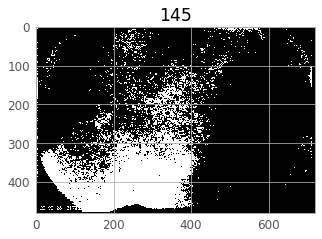

How about now?


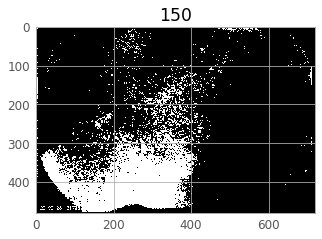

How about now?


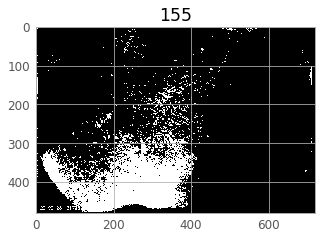

How about now?


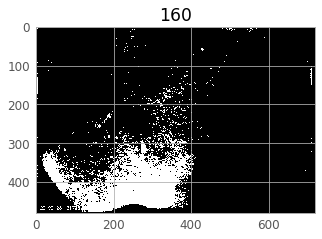

How about now?


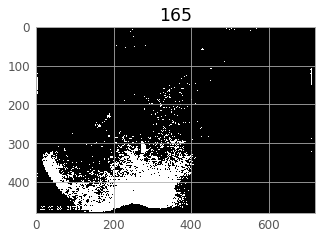

How about now?


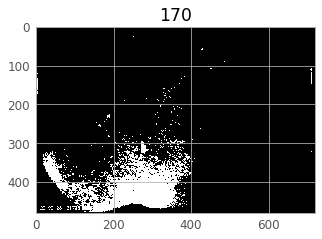

How about now?


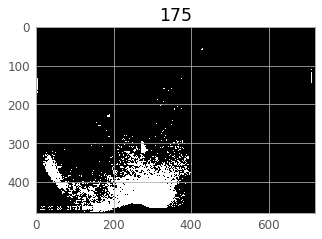

How about now?


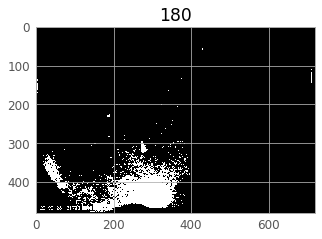

How about now?


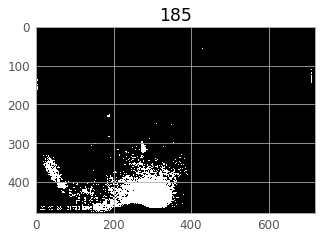

How about now?


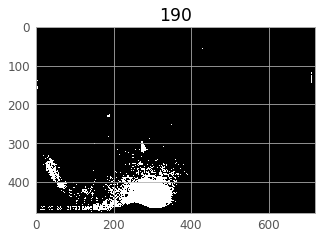

How about now?


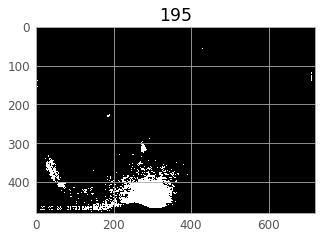

How about now?


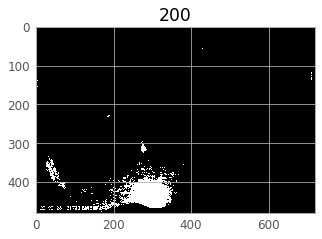

How about now?


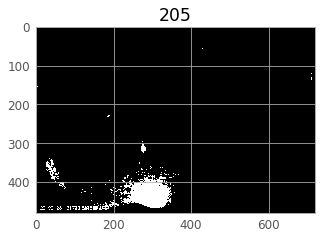

How about now?


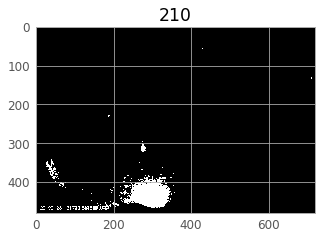

How about now?


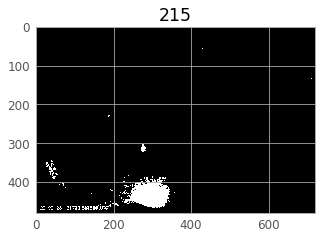

How about now?


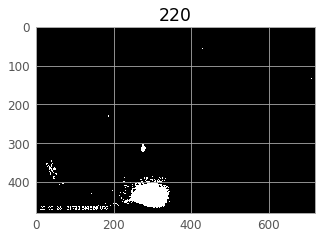

How about now?


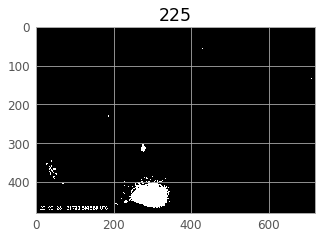

How about now?


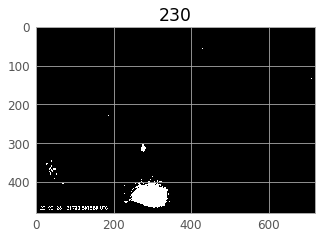

How about now?y


<Figure size 576x432 with 0 Axes>

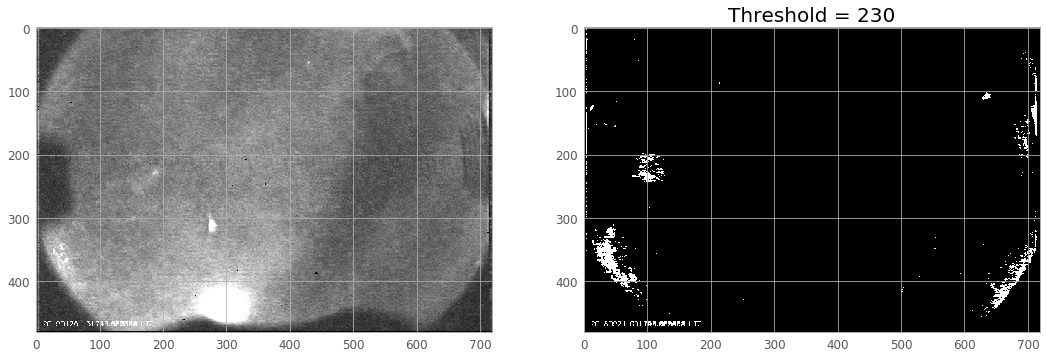

Is this threshold sufficient?y


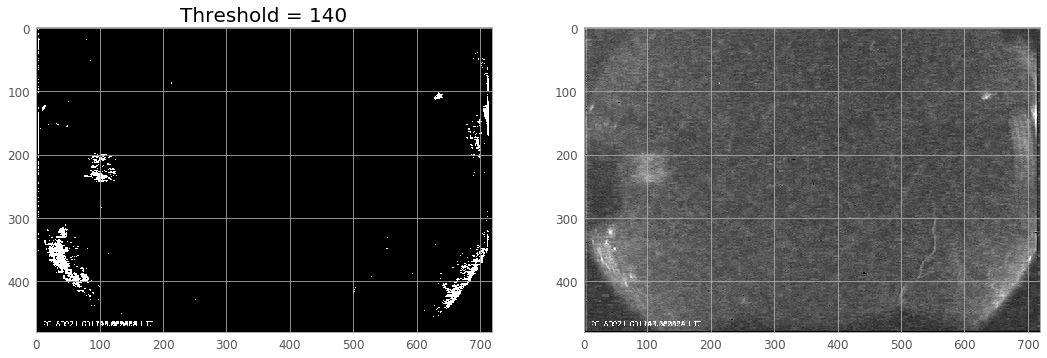

In [98]:
wildones = [onlyvids[0],onlyvids[132]]



path = vidpath

for i in np.arange(0,len(wildones)):
    
    wack = 0
    
    # Set up data array 
    data_array = np.chararray((100,11),itemsize=20)
    present_row = int(0)
    
    # Look at video
    vid = cv2.VideoCapture(path+wildones[i])
    vid.set(1,1)
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    init = frame.copy()

    stacksize = 10000

    frame = frame.astype(float)
    for j in range(stacksize):
        ret, newframe = vid.read()
        if not ret:
            stacksize = j
            break
        newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
        frame = cv2.add(frame, cv2.divide(newframe, stacksize))
    frame = cv2.convertScaleAbs(frame)
    
    ##################################################
    
    vid = cv2.VideoCapture(path+wildones[i])
    vid.set(1,1)
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    init = frame.copy()
    
    
    frame = frame.astype(float)
    for j in range(stacksize):
        ret, newframe = vid.read()
        if not ret:
            print('WTF!!!!!')
        newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
        frame = cv2.add(frame, cv2.divide(newframe, stacksize))
    frame = cv2.convertScaleAbs(frame)
    
    
    
    
    # Subtract dark frame to get rid of hot spots
    new = cv2.subtract(frame,th3)

    # Set original threshold
    thresh = 140
    
    # Threshold the image to try to find stars
    ret4,th4 = cv2.threshold(new,thresh,255,cv2.THRESH_BINARY)
    
    ##############################################
    # Check to see if threshold is sufficient
    ##############################################
    
    plt.imshow(th4, cmap='gray')
    plt.show()
    q1 = input('Is this threshold sufficient?')
    if q1 == 'n':
        bad = 0
        while bad == 0:
            thresh += 5
            ret4,th4 = cv2.threshold(new,thresh,255,cv2.THRESH_BINARY)
            fig = plt.figure(figsize=(5,5))
            plt.title(str(thresh))
            plt.imshow(th4, cmap='gray')
            plt.show()
            q2 = input('How about now?')
            if q2 == 'y':
                bad = 1
                plt.clf()
    
    ##############################################
    
  
    
    plt.figure(figsize=(18,18))
    
    if i == 0:
        thresh1 = thresh
        new1 = new
        pic1 = th4
        ax = plt.subplot(221)
        plt.imshow(new,cmap='gray')
        ax1 = plt.subplot(222)
        plt.title('Threshold = '+str(thresh),fontsize=20)
        plt.imshow(th4, cmap='gray',vmax=100, vmin=50)
        
    elif i == 1:
        thresh2 = thresh
        new2 = new
        pic2 = th4
        thresh2 = thresh
        ax2 = plt.subplot(224)
        plt.imshow(new,cmap='gray')
        ax3 = plt.subplot(223)
        plt.title('Threshold = '+str(thresh),fontsize=20)
        plt.imshow(th4, cmap='gray',vmax=100, vmin=50)
        plt.show()

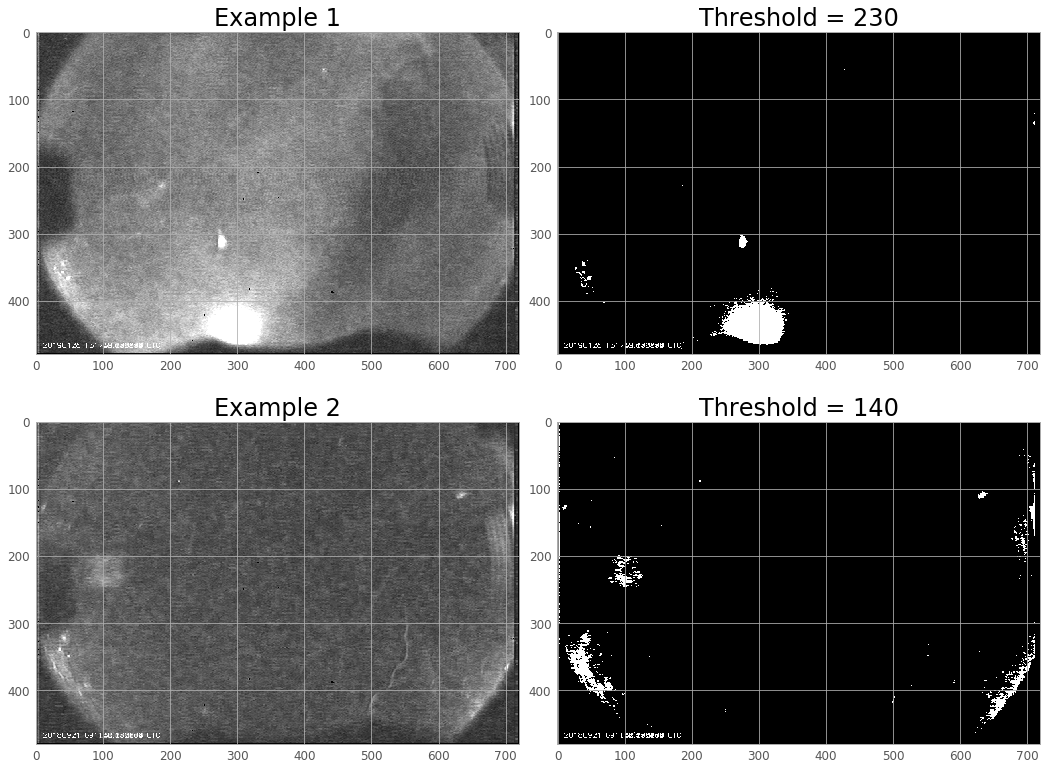

In [113]:
fig = plt.figure(figsize=(18,14))

ax = plt.subplot(221)
plt.imshow(new1,cmap='gray')
plt.title('Example 1',fontsize=24)
ax1 = plt.subplot(222)
plt.title('Threshold = '+str(thresh1),fontsize=24)
plt.imshow(pic1, cmap='gray',vmax=100, vmin=50)


ax2 = plt.subplot(223)
plt.imshow(new2,cmap='gray')
plt.title('Example 2',fontsize=24)
ax3 = plt.subplot(224)
plt.title('Threshold = '+str(thresh2),fontsize=24)
plt.imshow(pic2, cmap='gray',vmax=100, vmin=50)

plt.subplots_adjust(wspace=0.08, hspace=0.05)

plt.show()

#fig.savefig('images/different_thresholds.png',bbox_inches='tight')

In [15]:
vidpath2 = '/home/pj/UsbStick/starz/'

# Load Dark vid
vid = cv2.VideoCapture(vidpath2+'dark.avi')

# Start at first frame
vid.set(1,1)
# Read video
ret, frame = vid.read()
# Convert to black and white
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
# Create Copy of first frame
init = frame.copy()

# Set initial large stack number
stacksize = 10000

frame = frame.astype(float)
for i in range(stacksize):
    # Read in frame
    ret, newframe = vid.read()
    if not ret:
        # Find how many stacks are in the video and redefine it
        stacksize = i
        break
    # Make black and white but change to float to not run into int problem
    newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
    # Add fractional average to stacked frame
    frame = cv2.add(frame, cv2.divide(newframe, stacksize))


#####################################

# Reset process with known stacksize

vid.set(1,1)
ret, frame = vid.read()
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
init = frame.copy()

frame = frame.astype(float)
for i in range(stacksize):
    ret, newframe = vid.read()
    if not ret:
        print('Something is wrong...')
    newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
    frame = cv2.add(frame, cv2.divide(newframe, stacksize))
frame = cv2.convertScaleAbs(frame)
ret3,th3 = cv2.threshold(frame,140,255,cv2.THRESH_BINARY)

In [17]:
#Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByInertia = False
params.filterByConvexity = False
# We want white things
params.filterByColor = True
params.blobColor = 255
# We want small things
params.filterByArea = True
params.maxArea = 20
params.minArea = 1
# We want fairly circular things
params.filterByCircularity = True
params.minCircularity = 0.5

# Set detector to look for specified parameters
detector = cv2.SimpleBlobDetector_create(params)

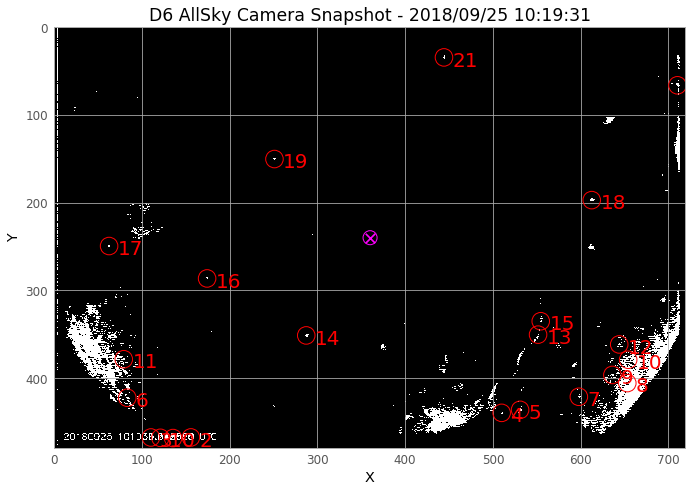

In [37]:

path = vidpath
vid_target = '20180925_101931.avi'

for i in np.arange(0,1):
    
    wack = 0
    
    # Set up data array 
    data_array = np.chararray((100,11),itemsize=20)
    present_row = int(0)
    
    # Look at video
    vid = cv2.VideoCapture(path+vid_target)
    vid.set(1,1)
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    init = frame.copy()

    stacksize = 10000

    frame = frame.astype(float)
    for j in range(stacksize):
        ret, newframe = vid.read()
        if not ret:
            stacksize = j
            break
        newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
        frame = cv2.add(frame, cv2.divide(newframe, stacksize))
    frame = cv2.convertScaleAbs(frame)
    
    ##################################################
    
    vid = cv2.VideoCapture(path+vid_target)
    vid.set(1,1)
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    init = frame.copy()
    
    
    frame = frame.astype(float)
    for j in range(stacksize):
        ret, newframe = vid.read()
        if not ret:
            print('WTF!!!!!')
        newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
        frame = cv2.add(frame, cv2.divide(newframe, stacksize))
    frame = cv2.convertScaleAbs(frame)
    
    
    
    
    # Subtract dark frame to get rid of hot spots
    new = cv2.subtract(frame,th3)

    # Set original threshold
    thresh = 160
    
    # Threshold the image to try to find stars
    ret4,th4 = cv2.threshold(new,thresh,255,cv2.THRESH_BINARY)
    

    ##############################################
    
    # Detect keypoints and find their locations
    keypoints = detector.detect(th4)
    x = [keypoints[j].pt[0] for j in np.arange(0,len(keypoints))]
    y = [keypoints[j].pt[1] for j in np.arange(0,len(keypoints))]
    locarray = np.column_stack((x,y))
    
    
    fig = plt.figure(figsize=(14,7))
    ax = plt.subplot(111)

    plt.imshow(th4, cmap='gray',vmax=100, vmin=50)

    for j in np.arange(0,len(x)):
        circle = plt.Circle((x[j], y[j]), 10, color='r', fill=False)
        ax.add_artist(circle)
        text = plt.annotate(str(j),(x[j]+10,y[j]+10), color='r')
        text.set_fontsize(20)

        
    nice_date = vid_target[i][:4]+'-'+vid_target[i][4:6]+'-'+vid_target[i][6:8]
    nice_time = vid_target[i][9:11]+':'+vid_target[i][11:13]    
    plt.title('D6 AllSky Camera Snapshot - 2018/09/25 10:19:31')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    
    cent = plt.Circle((360, 240), 8, color='fuchsia', fill=False)
    ax.add_artist(cent)
    plt.scatter(360,240,marker='x',color='fuchsia',s=90)
    plt.show()
    
    

    
    
    
    
    
    
    
    # Format date and time correctly
    date = vid_target[i][:4]+'-'+vid_target[i][4:6]+'-'+vid_target[i][6:8]
    time = vid_target[i][9:11]+':'+vid_target[i][11:13]+':'+vid_target[i][13:15]
    date_time = date+' '+time
    
    data_array1=[]
    
    #fig.savefig('FourStarz_OneFrame.png', bbox_inches='tight',pad_inches=0)
    

# Images to plot (optional)

## Finding the threshhold for dark.avi

In [ ]:
tryz = np.arange(100,205,5)

for i in np.arange(0,len(tryz)):
    fig = plt.figure(figsize=(10,5))
    ret3,th3 = cv2.threshold(frame,tryz[i],255,cv2.THRESH_BINARY)
    plt.subplot(121)
    plt.imshow(frame, cmap='gray',vmax=255, vmin=0)
    plt.subplot(122)
    plt.imshow(th3, cmap='gray')
    plt.title('thresh='+str(tryz[i]))
    plt.tight_layout()
    plt.show()

# Things I bailed on

In [ ]:
RA = m33.ra.deg
DEC = m33.dec.deg


# Calculate azimuth and elevation using info from web

dateinfo, hourinfo = onlyvids[i].split('_')

# Delve into fraction of day we are at

hourinfo = hourinfo.split('.avi')[0]
sec_cont = np.float(hourinfo[4:6])/60
min_cont = (np.float(hourinfo[2:4])+sec_cont)/60
hour_cont = (np.float(hourinfo[:2])+min_cont)/24
frac_cont = hour_cont

J2000 = '20000101'

# Find number of days since jan 1, 2000
d1 = datetime.datetime.strptime(dateinfo,'%Y%m%d')-datetime.datetime.strptime(J2000,'%Y%m%d')
d = d1.days + frac_cont

# Find universal time

UT = (np.float(hourinfo[:2])-4+min_cont)

# Enter longitude of Salem Oregon (west is negative)

LONG = --123.031752
LAT = 44.937309


##################################################
# Using these, calculate Local Steridium Time
##################################################

LST = 100.46 + 0.985647 * d + long + 15*UT

# Make sure it is between 0 and 360 
LST - int(LST/360)*360


##################################################
# Using these, calculate Hour Angle
##################################################

HA = LST - RA

if (HA < 0):
    HA += 360
elif (HA > 360):
    HA -= 360

##################################################
# Now calculate Az and El
##################################################
    

ALT = math.asin(math.sin(DEC)*math.sin(LAT)+math.cos(DEC)*math.cos(LAT)*math.cos(HA))

A = math.acos((math.sin(DEC) - math.sin(ALT)*math.sin(LAT)) / (math.cos(ALT)*math.cos(LAT)))

##########

if math.sin(HA) > 0:
    AZ = 360 - A
else:
    AZ = A
    
#########

ALT = np.rad2deg(ALT)
AZ = np.rad2deg(AZ)